In [67]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Panel
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
%matplotlib inline

names = ['AAPL', 'GOOG', 'MSFT', 'GS', 'MS', 'BAC', 'C']

def get_px(stock, start, end):
    return pdr.get_data_yahoo(stock, start, end)

#px = Panel({n: get_px(n, '1/1/2017', '9/30/2017') for n in names})
#px.to_csv('stock_prices.csv')

In [164]:
px = pd.read_csv('stock_prices.csv', index_col='Date', parse_dates=True)
px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 440 entries, 2016-01-04 to 2017-09-29
Data columns (total 7 columns):
AAPL    440 non-null float64
BAC     440 non-null float64
C       440 non-null float64
GOOG    440 non-null float64
GS      440 non-null float64
MS      440 non-null float64
MSFT    440 non-null float64
dtypes: float64(7)
memory usage: 27.5 KB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 440 entries, 2016-01-04 to 2017-09-29
Data columns (total 7 columns):
AAPL    439 non-null float64
BAC     439 non-null float64
C       439 non-null float64
GOOG    439 non-null float64
GS      439 non-null float64
MS      439 non-null float64
MSFT    439 non-null float64
dtypes: float64(7)
memory usage: 27.5 KB


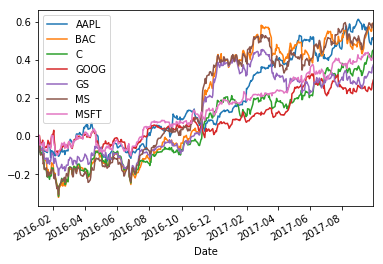

In [165]:
#px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()
rets.info()
((1 + rets).cumprod() - 1).plot()

In [166]:
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending = False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

compound = lambda x: (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr( prices, lb, hold): 
    # Compute portfolio weights 
    freq = '% dB' % hold 
    port = calc_mom( prices, lb, lag = 1)
    daily_rets = prices.pct_change() 
    
    # Compute portfolio returns 
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).compound()
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252/hold)

In [167]:
strat_sr( px, 70, 30)

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
.resample() is now a deferred operation
You called compound(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead


-1.2535070018989982

In [179]:
from collections import defaultdict 

lookbacks = range( 20, 90, 5) 
holdings = range( 20, 90, 5) 
dd = defaultdict(dict) 

for lb in lookbacks: 
    for hold in holdings: 
        dd[lb][hold] = strat_sr( px, lb, hold) 
ddf = DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

/Users/vicveiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 
.resample() is now a deferred operation
You called compound(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead


In [180]:
import matplotlib.pyplot as plt 

def heatmap( df, cmap = plt.cm.gray_r): 
    fig = plt.figure() 
    ax = fig.add_subplot( 111) 
    axim = ax.imshow( df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel( df.columns.name) 
    ax.set_xticks( np.arange( len( df.columns)))
    ax.set_xticklabels( list( df.columns))
    ax.set_ylabel( df.index.name)
    ax.set_yticks( np.arange( len( df.index)))
    ax.set_yticklabels( list( df.index))
    plt.colorbar( axim)

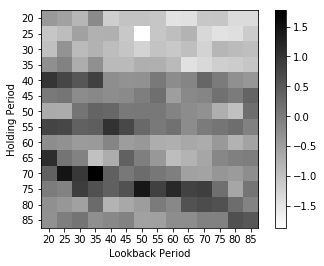

In [181]:
heatmap(ddf)